## Imports

In [ ]:
import numpy as np

import pandas as pd
import pickle
import json

from datetime import datetime, timedelta
import random
from typing import Dict, List, Tuple, Optional
import calendar

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

from koolbox import Trainer
from xgboost import XGBRegressor

from dataset_generator import CenterpointeDiningDataGenerator
from inference import StaffingPredictor

## Data Generation

In [2]:
growth_config = {
    'start_date': '2024-01-01',
    'end_date': '2025-07-31',
    'student_population': {
        'yoy_growth_rate': 0.028,  # Higher growth scenario
        'residential_student_ratio': 0.17,  # Planned housing expansion
    }
}

generator = CenterpointeDiningDataGenerator(growth_config)
df = generator.generate_dataset()

✓ Centerpointe Dataset Generator initialized
  Date range: 2024-01-01 to 2025-07-31
  Base enrollment: 31,000
  YoY growth rate: 2.8%

🏗️  Generating 578 days of Centerpointe dining data...
📅 Date range: January 01, 2024 → July 31, 2025
⏳ Progress: 25% (144/578 days)
⏳ Progress: 50% (289/578 days)
⏳ Progress: 75% (433/578 days)
⏳ Progress: 100% (578/578 days)

✅ Dataset generation complete!
📊 Generated 578 days of operational data
📈 Date range: 2024-01-01 to 2025-07-31

📋 Key Statistics:
   Average daily transactions: 1,018
   Peak daily transactions: 2,773
   Average daily revenue: $13,481.88
   Average staffing hours: 90.8
   Peak staffing hours: 243.4

🎓 Academic Period Distribution:
   Fall Semester: 100 days, 1571 trans/day, 132.3 hrs/day, $20,812/day
   Finals Weeks: 24 days, 1870 trans/day, 158.5 hrs/day, $24,772/day
   Move In Week: 8 days, 2034 trans/day, 174.6 hrs/day, $26,949/day
   Spring Break: 16 days, 465 trans/day, 48.1 hrs/day, $6,159/day
   Spring Semester: 211 days, 

In [3]:
# Create Train and Test Splits. Leave last year for testing
train_end_date = datetime.strptime('2024-12-31', '%Y-%m-%d')
test_start_date = datetime.strptime('2025-01-01', '%Y-%m-%d')
train_df = df[df['date'] <= train_end_date.strftime('%Y-%m-%d')]
test_df = df[df['date'] >= test_start_date.strftime('%Y-%m-%d')]
train_df.head()

,date,day_of_week,day_name,is_weekend,month,year,day_of_year,week_of_year,academic_period,period_type,...,actual_foh_general,actual_foh_cashier,actual_kitchen_prep,actual_kitchen_line,actual_dish_room,actual_management,total_actual_hours,revenue_per_labor_hour,transactions_per_labor_hour,labor_cost_percentage
0,2024-01-01,0,Monday,False,1,2024,1,1,winter_intersession,special,...,4.0,2.0,6.0,8.0,3.0,1.5,24.5,5.95,0.45,315.2
1,2024-01-02,1,Tuesday,False,1,2024,2,1,winter_intersession,special,...,4.0,2.0,6.0,8.0,3.0,1.5,24.5,6.49,0.49,288.9
2,2024-01-03,2,Wednesday,False,1,2024,3,1,winter_intersession,special,...,4.0,2.0,6.0,8.0,3.0,1.5,24.5,6.49,0.49,288.9
3,2024-01-04,3,Thursday,False,1,2024,4,1,winter_intersession,special,...,4.0,2.0,6.0,8.0,3.0,1.5,24.5,6.49,0.49,288.9
4,2024-01-05,4,Friday,False,1,2024,5,1,winter_intersession,special,...,4.0,2.0,6.0,8.0,3.0,1.5,24.5,5.41,0.41,346.7


In [4]:
available_features = [
    # Date and time features (all numerical)
    'day_of_week', 'month', 'year', 'day_of_year', 'week_of_year', 'is_weekend',

    # Academic cale ndar (we'll use encoded versions)
    'seasonal_multiplier',  # Keep numerical version

    # Student population (known from enrollment data)
    'total_enrollment', 'active_enrollment', 'residential_students',
    'commuter_students', 'total_meal_plan_holders', 'enrollment_seasonal_factor',

    # Environmental factors (we'll use numerical impacts and encoded categories)
    'weather_impact', 'event_impact',# 'campus_event',
]

# Features only known after the fact (actual operational results)
post_facto_features = [
    # Actual transaction volumes (what we're trying to predict staffing for)
    'total_transactions', 'guest_transactions',

    # Transaction breakdowns (unknown until day happens)
    'meal_swipes', 'dining_dollars_transactions', 'bronco_bucks_transactions',
    'credit_debit_transactions',

    # Meal period distributions (unknown until service)
    'breakfast_transactions', 'lunch_transactions', 'dinner_transactions',
    'late_night_transactions',

    # Operational metrics (results of actual operations)
    'transactions_per_meal_plan_holder', 'facility_capacity_utilization',
    'peak_meal_period_volume',

    # Financial results (depend on actual transactions)
    'estimated_daily_revenue', 'revenue_per_labor_hour', 'transactions_per_labor_hour',
    'labor_cost_percentage',
]

# Target variables (what we're predicting)
target_features = [
    'actual_foh_general', 'actual_foh_cashier', 'actual_kitchen_prep',
    'actual_kitchen_line', 'actual_dish_room', 'actual_management',
    'total_actual_hours', 'labor_cost_actual'
]

## Transaction Prediction Model

In [5]:
target = 'total_transactions'

y = train_df[target]
X = train_df[available_features]

In [6]:
tx_estimator = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    max_depth=8,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

tx_trainer = Trainer(
    tx_estimator,
    cv=TimeSeriesSplit(n_splits=5),
    metric=r2_score,
    task="regression",
    metric_precision=6,
    use_early_stopping=True,  # Enable early stopping
    verbose=True
)

tx_trainer.fit(X, y)

y_pred = tx_trainer.predict(X)

# save model as pickle file
import pickle
with open('tx_model.pkl', 'wb') as f:
    pickle.dump(tx_trainer, f)

Training XGBRegressor

[0]	validation_0-rmse:396.37361
[1]	validation_0-rmse:382.73684
[2]	validation_0-rmse:374.41139
[3]	validation_0-rmse:363.92422
[4]	validation_0-rmse:357.16410
[5]	validation_0-rmse:352.01575
[6]	validation_0-rmse:348.76118
[7]	validation_0-rmse:346.69140
[8]	validation_0-rmse:345.36617
[9]	validation_0-rmse:343.73611
[10]	validation_0-rmse:343.92426
[11]	validation_0-rmse:344.81264
[12]	validation_0-rmse:343.79431
[13]	validation_0-rmse:342.26074
[14]	validation_0-rmse:342.36778
[15]	validation_0-rmse:343.68933
[16]	validation_0-rmse:344.66890
[17]	validation_0-rmse:345.83665
[18]	validation_0-rmse:345.81430
[19]	validation_0-rmse:345.63678
[20]	validation_0-rmse:345.73780
[21]	validation_0-rmse:345.58895
[22]	validation_0-rmse:346.06845
[23]	validation_0-rmse:345.83789
[24]	validation_0-rmse:346.18301
[25]	validation_0-rmse:347.83736
[26]	validation_0-rmse:348.07699
[27]	validation_0-rmse:348.57088
[28]	validation_0-rmse:349.19951
[29]	validation_0-rmse:349.124

## Staffing Prediction Model

In [7]:
X['total_transactions'] = y_pred
y = train_df[target_features]

/var/folders/4g/zdc8n6kn3hzgvqwnynl5sslh0000gn/T/ipykernel_88398/787865235.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['total_transactions'] = y_pred


In [8]:
work_estimator = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    max_depth=8,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

cv = TimeSeriesSplit(n_splits=5)
fold = 1
for train_index, val_index in cv.split(X):
    print(f"Fold {fold}")
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    work_estimator.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = work_estimator.predict(X_val)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    val_mape = mean_absolute_percentage_error(y_val, y_val_pred)
    
    fold += 1

    print(f"Validation Set Evaluation:")
    print(f"  Mean Absolute Error (MAE): {val_mae:.2f}")
    print(f"  Mean Squared Error (MSE): {val_mse:.2f}")
    print(f"  R-squared (R2): {val_r2:.4f}")
    print(f"  Mean Absolute Percentage Error (MAPE): {val_mape:.2%}")
    
# Save the trained model
import pickle
with open('work_model.pkl', 'wb') as f:
    pickle.dump(work_estimator, f)

Fold 1
Validation Set Evaluation:
  Mean Absolute Error (MAE): 20.36
  Mean Squared Error (MSE): 9976.30
  R-squared (R2): 0.9126
  Mean Absolute Percentage Error (MAPE): 10.66%
Fold 2
Validation Set Evaluation:
  Mean Absolute Error (MAE): 40.54
  Mean Squared Error (MSE): 13641.80
  R-squared (R2): 0.9290
  Mean Absolute Percentage Error (MAPE): 32.21%
Fold 3
Validation Set Evaluation:
  Mean Absolute Error (MAE): 9.80
  Mean Squared Error (MSE): 3251.10
  R-squared (R2): 0.9874
  Mean Absolute Percentage Error (MAPE): 3.29%
Fold 4
Validation Set Evaluation:
  Mean Absolute Error (MAE): 21.36
  Mean Squared Error (MSE): 7747.82
  R-squared (R2): 0.9011
  Mean Absolute Percentage Error (MAPE): 5.77%
Fold 5
Validation Set Evaluation:
  Mean Absolute Error (MAE): 8.61
  Mean Squared Error (MSE): 2173.56
  R-squared (R2): 0.9826
  Mean Absolute Percentage Error (MAPE): 4.91%


## Frontend Inference

In [9]:
# Initialize the predictor
predictor = StaffingPredictor()

# Load your trained models
predictor.load_models('tx_model.pkl', 'work_model.pkl')

print("Example prediction pipeline:")
test_date = datetime(2025, 10, 30)
test_weather = 'cloudy'
test_event = 'club_fair'

print(f"Date: {test_date.strftime('%A, %B %d, %Y')}")
print(f"Weather: {test_weather}")
print(f"Event: {test_event}")

# Predict staffing requirements
staffing_predictions = predictor.predict_staffing_requirements(
    date=test_date,
    weather=test_weather,
    event=test_event,
    target_features=['actual_foh_general', 'actual_foh_cashier', 'actual_kitchen_prep',
                     'actual_kitchen_line', 'actual_dish_room', 'actual_management']
)
print("Staffing predictions:")
print(staffing_predictions)

Example prediction pipeline:
Date: Thursday, October 30, 2025
Weather: cloudy
Event: club_fair
Staffing predictions:
{'actual_foh_general': 43.8, 'actual_foh_cashier': 19.8, 'actual_kitchen_prep': 41.3, 'actual_kitchen_line': 58.6, 'actual_dish_room': 29.9, 'actual_management': 10.5, 'total_predicted_hours': 203.9, 'predicted_transactions': 1940}


<Axes: >

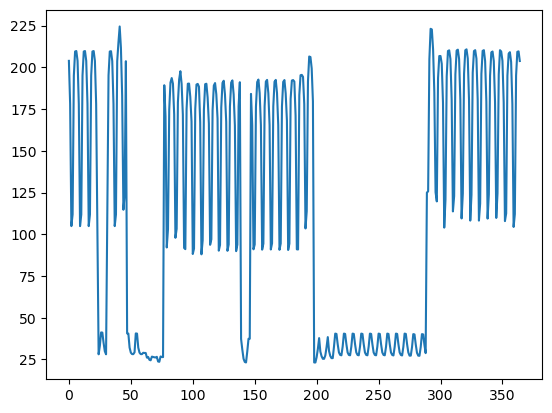

In [10]:
batch_dates = []
days = 365
for i in range(days):
    batch_dates.append(test_date + timedelta(days=i))
    
batch_weather = ['cloudy'] * days
batch_events = ['club_fair'] * days

# Predict staffing requirements for a batch of dates
batch_predictions = predictor.batch_predict(
    dates=batch_dates,
    weather_conditions=batch_weather,
    events=batch_events,
    target_features=['actual_foh_general', 'actual_foh_cashier', 'actual_kitchen_prep',
                     'actual_kitchen_line', 'actual_dish_room', 'actual_management']
)
batch_predictions['total_predicted_hours'].plot()

In [11]:
# Test batch prediction
batch_dates = [
    datetime(2025, 7, 30), datetime(2025, 7, 31), datetime(2025, 8, 1),
    datetime(2025, 8, 2), datetime(2025, 8, 3)
]
batch_weather = ['sunny', 'cloudy', 'rainy', 'sunny', 'extreme_heat']
batch_events = ['club_fair', 'regular_day', 'career_fair', 'sports_events', 'graduation']

batch_predictions = predictor.batch_predict(
    dates=batch_dates,
    weather_conditions=batch_weather,
    events=batch_events,
    target_features=['actual_foh_general', 'actual_foh_cashier', 'actual_kitchen_prep',
                     'actual_kitchen_line', 'actual_dish_room', 'actual_management']
)
print("Batch predictions:")
print(batch_predictions)

Batch predictions:
   actual_foh_general  actual_foh_cashier  actual_kitchen_prep  \
0                 7.2                 3.6                  8.6   
1                 4.2                 2.3                  6.2   
2                 4.0                 2.4                  6.6   
3                 3.7                 1.7                  5.4   
4                 5.2                 1.9                  6.4   

   actual_kitchen_line  actual_dish_room  actual_management  \
0                 12.1               6.8                2.4   
1                  8.7               3.4                1.6   
2                  9.6               3.5                1.5   
3                  7.6               2.8                1.3   
4                  9.6               4.8                1.4   

   total_predicted_hours  predicted_transactions        date       weather  \
0                   40.7                     667  2025-07-30         sunny   
1                   26.4                     553 

In [12]:
# Additional utility methods
print(f"Available weather conditions: {predictor.get_available_weather_conditions()}")
print(f"Available events: {predictor.get_available_events()}")
print(f"Default staffing roles: {predictor.get_default_staffing_roles()}")
print(f"Predictor status: {predictor}")

Available weather conditions: ['sunny', 'cloudy', 'rainy', 'extreme_heat']
Available events: ['regular_day', 'club_fair', 'career_fair', 'sports_events', 'graduation', 'parent_weekend', 'prospective_student_day', 'conference_hosting', 'campus_construction']
Default staffing roles: ['actual_foh_general', 'actual_foh_cashier', 'actual_kitchen_prep', 'actual_kitchen_line', 'actual_dish_room', 'actual_management']
Predictor status: StaffingPredictor(tx_model=✓, work_model=✓)


In [ ]:
batch_predictions